# Práctica 2

In [1]:
from sklearn.datasets import fetch_20newsgroups

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise        import cosine_similarity

import random
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Obtención de los datos de entrenamiento y prueba
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=17)
test_data  = fetch_20newsgroups(subset='test',  shuffle=True, random_state=398)
# print(test_data.data[0])

In [3]:
# Lectura del diccionario de palabras
with open('words.txt') as file:
    dictionary = file.read().splitlines()

In [4]:
# Vectorizador de documentos común a los apartados a y b
vectorizer = CountVectorizer(analyzer='word',stop_words='english', binary=False, vocabulary=dictionary, ngram_range=(1,1))

In [5]:
# Obtención de los datos vectorizados con respecto a un diccionario
# Las matrices dispersas las compacta en listas de índices
train_data_vectorized = vectorizer.fit_transform(train_data.data)
test_data_vectorized = vectorizer.transform(test_data.data)
# print(train_data_vectorized[180])

In [6]:
# Para el Apartado b
# Usamos los datos "train_data_vectorized" transformados con tf-idf
tfidfer = TfidfTransformer()
train_data_tfidf = tfidfer.fit_transform(train_data_vectorized)
test_data_tfidf = tfidfer.transform(test_data_vectorized)

In [7]:
# Para poder saber la clase de los documentos ya introducidos usaremos:
tdv_tuplas = list(zip(train_data_vectorized,train_data.target))
tdt_tuplas = list(zip(train_data_tfidf,train_data.target))
# print(tdv_tuplas)

In [8]:
# Otra forma es con esta función, menos eficiente que la opción anterior:
# msj es una fila de train_data_(tfidf o vectorized, según el 2º parámetro)
# y devuelve su clase
def get_clase_train(msj,train_data_):
    for i,row in enumerate(train_data_):
        if (row-msj).nnz==0: #Dos filas de matriz dispersa se comparan así
            return train_data.target[i]
    return -1
# Igual que get_clase_train pero para los valores de test
def get_clase_test(msj,test_data_):
    for i,row in enumerate(test_data_):
        if (row-msj).nnz==0:
            return test_data.target[i]
    return -1

## Práctica 2.2.a

In [9]:
# Usamos los datos "train_data_vectorized" y "test_data_vectorized"
# sin modificaciones

In [10]:
# Función auxiliar que calculará cuantos de los documentos obtenidos tras la
# consulta son de la misma clase que la consulta (i.e. relevantes)
def precision(clase_consulta,docs_clase):
    # Cogemos las clases de los documentos pasados, que son el segundo elemento
    # de las tuplas que conforman docs_clase
    clases = [x[1] for x in docs_clase]
    # Vemos cuantas son iguales a la clase pasada
    return len(list(filter(lambda x: x==clase_consulta,clases)))

In [11]:
# Función que dada una consulta nos devuelve los resultados más similares
# en forma de tupla (elemento,clase)
def buscador(consulta,train_data_,td_tuplas):
    # Calculamos la similitud del coseno entre la consulta (que es un elemento de test)
    # y cada uno de los elementos de entrenamiento
    relevancia = cosine_similarity(train_data_,consulta,dense_output=True)
    # Cambiamos formato de relevancia de por ejemplo [[2],[5]] a [2,5]
    relevancia = [x[0] for x in relevancia] 
    # Ordenamos los documentos según la relevancia de mayor a menor
    return [x for _,x in sorted(zip(relevancia,td_tuplas),reverse=True,key=lambda tup: tup[0])]

In [12]:
#Calculamos las precisiones para cada clase y nivel de exhaustividad

# Devuelve una lista que tiene en la posición i-ésima una lista con
# la precisión media para cada nivel de exhaustividad para la clase i
def calcula_precisiones(train_data_,test_data_,consultas_x_clase, exhausts):
    # Clasificamos los datos vectorizados según su clase
    # En docs_clases[i] van los documentos de la clase i
    docs_clases = [[] for _ in range(len(test_data.target_names))]
    # Entre test_data_ y test_data.target hay una correspondencia 1-1
    for i,mensaje in enumerate(test_data_):
        docs_clases[test_data.target[i]].append(mensaje)

    # Para cada clase: calculamos similitud con los documentos y hacemos ranking
    # Para que salgan los mismos resultados usaremos rand
    rand = random.Random(458)
    ranking = []
    result = []
    for clase,docs_clase in enumerate(docs_clases):
        # Escogemos 3 mensajes
        mensajes_consulta = rand.sample(docs_clase,consultas_x_clase)
        # Guardaremos el ranking para usarlo en el análisis
        ranking_clase = []
        # Calculamos las precisiones para cada consulta
        temp_exhausts = [0 for _ in range(len(exhausts))]
        for msj in mensajes_consulta:
            # Cogemos los documentos más similares
            docs_clase_ord = buscador(msj,train_data_,tdv_tuplas)
            # Guardamos el ranking
            ranking_clase.append(docs_clase_ord)
            # Revision de que la clase del mensaje es correcta
            # print(clase==get_clase_test(msj,test_data_))
            # Anotamos la precisión de esta consulta variando el nivel de exhaustividad
            for i,exh in enumerate(exhausts):
                temp_exhausts[i] += precision(clase,docs_clase_ord[:exh])/exh
        # Guardamos los rankings de esta clase
        ranking.append(ranking_clase)
        # Calculamos la precisión media para cada nivel de exhaustividad en esta clase
        temp_exhausts = list(map(lambda x: x/consultas_x_clase,temp_exhausts))
        # DUDA: he entendido bien la def de precisión?: es el num de resultados relevantes solo,
        # o hay que dividirla por el total de resultados considerados (nivel de exhaustividad)?
        result.append(temp_exhausts)
    return result,ranking

resultado_v = calcula_precisiones(train_data_vectorized,test_data_vectorized,
                                        3,[3,10])
vectorized_results = resultado_v[0]
vectorized_ranking = resultado_v[1]
print(vectorized_results)

[[0.3333333333333333, 0.26666666666666666], [0.4444444444444444, 0.2333333333333333], [0.7777777777777777, 0.7999999999999999], [0.2222222222222222, 0.3666666666666667], [0.6666666666666666, 0.3333333333333333], [0.5555555555555555, 0.3333333333333333], [0.3333333333333333, 0.3333333333333333], [0.5555555555555555, 0.39999999999999997], [0.8888888888888888, 0.5333333333333333], [0.2222222222222222, 0.3], [0.7777777777777778, 0.7999999999999999], [0.6666666666666666, 0.43333333333333335], [0.3333333333333333, 0.16666666666666666], [0.0, 0.03333333333333333], [1.0, 0.8666666666666666], [0.6666666666666666, 0.5666666666666668], [0.6666666666666666, 0.5666666666666667], [0.7777777777777777, 0.6666666666666666], [0.7777777777777777, 0.7333333333333334], [0.1111111111111111, 0.06666666666666667]]


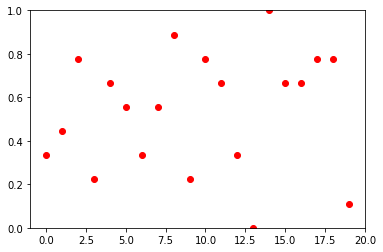

In [13]:
def show(datos_precision):
    # Eje x: clase
    # Eje y: precisión
    num_clases = len(test_data.target_names)
    plt.plot(range(num_clases),datos_precision,'ro')
    plt.axis([-1,num_clases,0,1])
    plt.show()
    
# Nivel de exhaustividad 3
precision_3_v = [x[0] for x in vectorized_results]
show(precision_3_v)

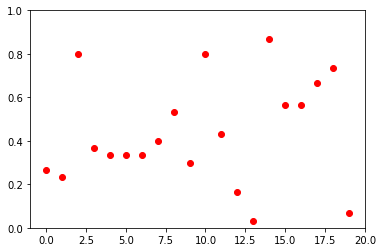

In [14]:
# Nivel de exhaustividad 10
precision_10_v = [x[1] for x in vectorized_results]
show(precision_10_v)

In [15]:
#Tabla de precisiones
d_v = {'Precision Exhaus 3':precision_3_v,'Precision Exhaus 10':precision_10_v}
df_v = pd.DataFrame(data=d_v,index=test_data.target_names)
print(df_v)

                          Precision Exhaus 3  Precision Exhaus 10
alt.atheism                         0.333333             0.266667
comp.graphics                       0.444444             0.233333
comp.os.ms-windows.misc             0.777778             0.800000
comp.sys.ibm.pc.hardware            0.222222             0.366667
comp.sys.mac.hardware               0.666667             0.333333
comp.windows.x                      0.555556             0.333333
misc.forsale                        0.333333             0.333333
rec.autos                           0.555556             0.400000
rec.motorcycles                     0.888889             0.533333
rec.sport.baseball                  0.222222             0.300000
rec.sport.hockey                    0.777778             0.800000
sci.crypt                           0.666667             0.433333
sci.electronics                     0.333333             0.166667
sci.med                             0.000000             0.033333
sci.space 

In [16]:
# Estadísticos principales
print(df_v.describe())

       Precision Exhaus 3  Precision Exhaus 10
count           20.000000            20.000000
mean             0.538889             0.440000
std              0.275193             0.244136
min              0.000000             0.033333
25%              0.333333             0.291667
50%              0.611111             0.383333
75%              0.777778             0.591667
max              1.000000             0.866667


#### Comentarios

DUDA: Habria que hablar de los dos niveles de exhaustividad por separado?

El valor de precisión varía muchísimo al cambiar de clase. Vemos que, por ejemplo, acierta muy poco con los documentos mostrados cuando la consulta es de clase 'sci.med' y que acierta mucho si la consulta es de 'sci.space'.

Un vistazo a los cuantiles nos permite ver que, con un nivel de exhaustividad 3, la mitad de las clases tienen más de un 0.6 de precisión y un 25% de las clases tienen más de un 0.77 de precisión, lo cual está francamente bien.

Al aumentar el nivel de exhaustividad a 10 las cosas cambian ligeramente: hay menos casos extremos, es decir, siempre acierta y falla alguno. También empeoran ligeramente los resultados: la mitad de las clases tienen más de un 0.38 de precisión y un 25% de las clases tienen más de un 0.59 de precisión.

DUDA: Esto puede deberse a? Que estan muy esparcidos y eso hace que sea probable fallar?

In [17]:
# Clase con peores resultados de precisión: 'sci.med'

def clases_confusion(nombre_clase,ranking):
    # Cogemos los rankings de las consultas de la clase pasada
    clase = test_data.target_names.index(nombre_clase)
    ranking_clase = ranking[clase]
    # Nos quedamos con los 2 primeros documentos del ranking para cada consulta
    lista_docs = [rank_consult[:2] for rank_consult in ranking_clase]
    # Pasamos de lista de listas a lista, guardamos sus clases y eliminamos repetidos
    set_clases = set([doc[1] for sublista in lista_docs for doc in sublista])
    # Cambiamos el numero de la clase por su nombre
    lista_nombre_clases = list(map(lambda i:test_data.target_names[i],set_clases))
    return lista_nombre_clases

print(clases_confusion('sci.med',vectorized_ranking))

['comp.graphics', 'comp.os.ms-windows.misc', 'misc.forsale', 'rec.sport.hockey', 'sci.crypt']


Vemos que la clase 'sci.med' se confunde habitualmente con las clases 'comp.graphics', 'comp.os.ms-windows.misc', 'misc.forsale', 'rec.sport.hockey' y 'sci.crypt'.
Este tipo de error significa que 'sci.med' no tiene características que permitan distinguir claramente, lo cual no quiere decir que las clases con las que se confundan tengan mala precisión. Estas podrían tener características que, de aparecer, no dejasen lugar a dudas de a que clase corresponde el texto.

DUDA: uff no tengo ni idea de qué decir

## Práctica 2.2.b

In [18]:
# Usamos los datos "train_data_tfidf" y "test_data_tfidf"
# sin modificaciones

In [19]:
# Repetimos lo anterior para los nuevos datos
resultado_t = calcula_precisiones(train_data_tfidf,test_data_tfidf,3,[3,10])
tfidf_results = resultado_t[0]
tfidf_ranking = resultado_t[1]
print(tfidf_results)

[[0.3333333333333333, 0.2333333333333333], [0.4444444444444444, 0.3666666666666667], [0.6666666666666666, 0.8666666666666667], [0.5555555555555555, 0.5333333333333333], [0.5555555555555555, 0.4333333333333333], [0.4444444444444444, 0.4666666666666666], [0.2222222222222222, 0.3333333333333333], [0.7777777777777778, 0.5666666666666667], [0.7777777777777777, 0.7333333333333334], [0.5555555555555555, 0.4666666666666666], [1.0, 0.9333333333333332], [0.6666666666666666, 0.6333333333333334], [0.2222222222222222, 0.2333333333333333], [0.0, 0.06666666666666667], [0.8888888888888888, 0.9], [0.8888888888888888, 0.6333333333333333], [0.7777777777777777, 0.6333333333333334], [0.7777777777777778, 0.6666666666666666], [0.5555555555555555, 0.7000000000000001], [0.1111111111111111, 0.10000000000000002]]


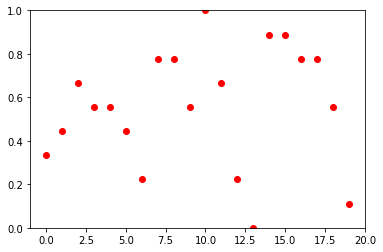

In [20]:
precision_3_t = [x[0] for x in tfidf_results]
show(precision_3_t)

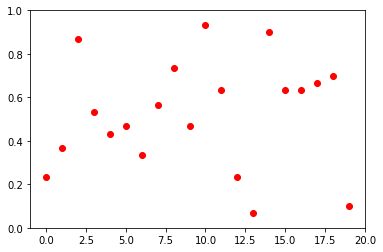

In [21]:
precision_10_t = [x[1] for x in tfidf_results]
show(precision_10_t)

In [22]:
d_t = {'Precision Exhaus 3':precision_3_t,'Precision Exhaus 10':precision_10_t}
df_t = pd.DataFrame(data=d_t,index=test_data.target_names)
print(df_t)

                          Precision Exhaus 3  Precision Exhaus 10
alt.atheism                         0.333333             0.233333
comp.graphics                       0.444444             0.366667
comp.os.ms-windows.misc             0.666667             0.866667
comp.sys.ibm.pc.hardware            0.555556             0.533333
comp.sys.mac.hardware               0.555556             0.433333
comp.windows.x                      0.444444             0.466667
misc.forsale                        0.222222             0.333333
rec.autos                           0.777778             0.566667
rec.motorcycles                     0.777778             0.733333
rec.sport.baseball                  0.555556             0.466667
rec.sport.hockey                    1.000000             0.933333
sci.crypt                           0.666667             0.633333
sci.electronics                     0.222222             0.233333
sci.med                             0.000000             0.066667
sci.space 

In [23]:
print(df_t.describe())

       Precision Exhaus 3  Precision Exhaus 10
count           20.000000            20.000000
mean             0.561111             0.525000
std              0.275664             0.250584
min              0.000000             0.066667
25%              0.416667             0.358333
50%              0.555556             0.550000
75%              0.777778             0.675000
max              1.000000             0.933333


#### Comentarios

DUDA: no hace bien los enter si no es para nuevo párrafo, preguntar JC

Para nivel de exhaustividad 3, la media ha subido de un 0.539 a un 0.561, la desviación típica se mantiene similar, el primer cuantil ha mejorado de 0.33 a 0.41, la mediana ha empeorado de 0.61 a 0.55 y el tercer cuantil se mantiene. Esto quiere decir que los casos en los que había baja precisión han mejorado, pero en los que había alta se han mantenido estables.

Para nivel de exhaustividad 10, todo ha mejorado. Es especialmente notable que un 50% de las clases tienen más del 0.55 de precisión y un 25% de las clases tienen más del 0.675 de precisión, lo cual es muy positivo.

Nivel de exhaustividad 3:
Clases que han mejorado (7): 'comp.sys.ibm.pc.hardware', 'rec.autos', 'rec.sport.baseball', 'rec.sport.hockey', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast'
Clases que han empeorado (8): 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.motorcycles', 'sci.electronics', 'sci.space', 'talk.politics.misc'
Clases que se mantienen (5): restantes

Nivel de exhaustividad 10:
Clases que han empeorado (2): 'alt.atheism', 'talk.politics.misc'
Clases que se mantienen (2): 'misc.forsale', 'talk.politics.mideast'
Clases que han mejorado (16): 'restantes'

In [24]:
#df_t - df_v

Hay un empate entre las dos clases que más han mejorado con nivel de exhaustividad 10, así que escogemos de esas la que más ha mejorado con nivel de exhaustividad 3: 'sci.crypt'.

Tf-idf significa term-frequency times inverse document-frequency, es decir, minimiza el impacto de términos con frecuencias muy altas (y seguramente no informativos) y aumenta el impacto de términos con poca frecuencia (pero que pueden ser, por ejemplo, tecnicismos).

Veamos qué ha pasado en el caso concreto de 'sci.crypt' mostrando las frecuencias antes y después de usar tf-idf.
Lo compararemos con 'rec.sport.hockey', cuya precisión aumentó 0.13 al usar tf-idf frente a los 0.2 de 'sci.crypt', con el objetivo de visualizar entre que valores oscilan las frecuencias tras pasar por el tf-idf.
Como es una matriz dispersa, mostramos los valores de la versión comprimida en un array para poder verlos todos.

In [25]:
num_clase = test_data.target_names.index('rec.sport.hockey')
print(test_data_vectorized[num_clase].data)
print()
print(np.flip(test_data_tfidf[num_clase].data))
# Las tuplas aparecian en orden inverso, de ahí el flip

[1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 2 1 1 1 3 1 1 1
 1 1 1 1 1 1 1]

[0.09634314 0.12785479 0.10142332 0.07766332 0.10028107 0.10162125
 0.05531737 0.12881632 0.11303802 0.09903719 0.10329174 0.09649053
 0.08259555 0.12989615 0.14793198 0.07659876 0.08547652 0.19911877
 0.06789368 0.096197   0.06888689 0.07448095 0.09053712 0.09242015
 0.08800302 0.11840926 0.08299831 0.11642791 0.096197   0.1102043
 0.07811842 0.06471261 0.10894425 0.05587561 0.06216837 0.06485495
 0.09920951 0.16695768 0.15993586 0.12623671 0.06809356 0.08334125
 0.01737466 0.09649053 0.08077092 0.10243636 0.13743496 0.06433866
 0.01801596 0.08018382 0.16695768 0.10776971 0.08239763 0.06108132
 0.08516588 0.12005984 0.0512265  0.12125465 0.08547652 0.08981758
 0.34446016 0.06277025 0.08729244 0.10396219 0.11949199 0.11228495
 0.13141885 0.07415186 0.01731794 0.11949199 0.31188658 0.11156326
 0.04201735 0.13325853 0.05945

Vemos como las frecuencias cambian por completo a valores todos pequeños, premiando o castigando muchas palabras hasta el punto de que una palabra que antes tenía frecuencia menor que otra puede pasar a tener ahora más.

En el caso de 'rec.sport.hockey', vemos que por ejemplo sigue premiando la palabra que tiene 4 de frecuencia, pasándola a 0.34 (que ahora ya no es el cuádruple con respecto a las que tenían frecuencia 1, sino el triple (de media)) o el 3, que lo pasa a 0.31. Sin embargo, también castiga ciertas palabras, como el 2 entre el 4 y el 3, que pasa a valer 0.13, prácticamente como muchas palabras con frecuencia original 1.

In [26]:
num_clase = test_data.target_names.index('sci.crypt')
print(test_data_vectorized[num_clase].data)
print()
print(np.flip(test_data_tfidf[num_clase].data))

[1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 1 1 1 2 1 1 1 1 3 1 1
 1 1 1 1 2 1 2 1 1 1 1 2 1 1 1 1]

[0.07269942 0.1485265  0.12300855 0.10819534 0.03547855 0.08756266
 0.09975685 0.11759424 0.30683187 0.09308108 0.12727706 0.12879612
 0.14571093 0.11426827 0.15965561 0.0932826  0.27442779 0.12727706
 0.094608   0.07191411 0.11759424 0.10505371 0.14396044 0.12185865
 0.1167098  0.22108298 0.20789628 0.08706094 0.14571093 0.13646903
 0.10791396 0.02018381 0.14313919 0.02092881 0.1503304  0.08964845
 0.09929647 0.11209124 0.0973873  0.1242282  0.10630367 0.14364195
 0.11805149 0.21963488 0.13419303 0.02011792 0.09789027 0.08571925
 0.31931122 0.09587276 0.15480393 0.11465516 0.03372234]


En el caso de 'sci.crypt', llama la atención la variación de ciertas palabras. La segunda palabra con una frecuencia original de 3 pasó a valer 0.221, prácticamente lo mismo que la palabra que tiene a continuación: pasó de 1 a 0.207. Son unos cambios que desde luego pueden repercurtir mucho en la similitud del coseno.
Sin embargo, parece que el motivo de la especial subida de este pueda ser que los mayores valores que se alcanzan, 0.3068 y 0.3193, se corresponden con la segunda y la última palabra que tenía valor 2, experimentando una enorme subida que supera incluso a los que tenían frecuencia 3 en este ejemplo y alcanzando casi a la palabra con frecuencia 4 del ejemplo anterior.
Sin duda esas serán palabra que aparezcan en muy pocos textos, y que gracias al tf-idf ahora pasan a ser determinante.